# Intrasensor divergence for a single sensor

In [1]:
from publicdata import client as c
from functions import *
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd
# %matplotlib widget  #

/home/fredrik/time_series_gan_project/functions.py:117: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm is "log":


In [2]:
# Nine sensors related to the inputs, outputs and controls of a compressor subsystem.
# Dictionary made with key=name of sensor and value=Id of sensor
sensors = {
    'PDT-92534': 6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':7638223843994790,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}
sensor_name = "PT-92523"

days = range(5, 14)
days_df = {}

for day in days:
    startdate = datetime(2018, 11, day, tzinfo=timezone.utc)
    enddate = datetime(2018, 11, day+1, tzinfo=timezone.utc)
    print(f'Retrieved day {day}')
    res = c.time_series.data.retrieve_dataframe(id=sensors[sensor_name], 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id',
                                                aggregates=["average"],
                                                granularity="30s",)
    days_df[startdate.strftime("%d/%m/%Y")] = res

print("Data retrieved")



Retrieved day 5
Retrieved day 6
Retrieved day 7
Retrieved day 8
Retrieved day 9
Retrieved day 10
Retrieved day 11
Retrieved day 12
Retrieved day 13
Data retrieved


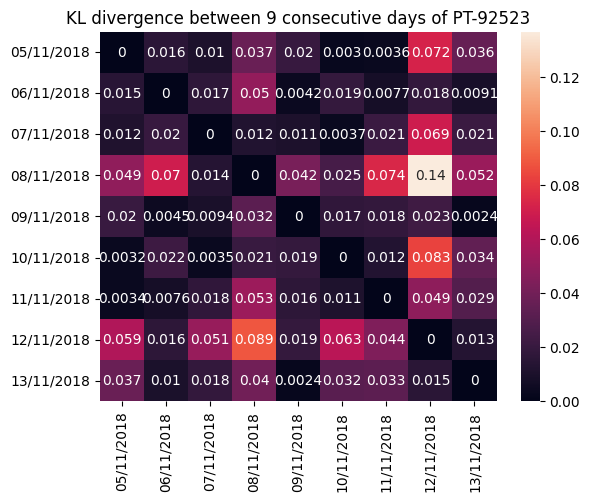

In [3]:
# print(days_df)

# plot_all_nine_sensors(days_df)

days_KL = kl_dfs(days_df)
plot_kl(days_KL, axis_labels=days_df.keys(), title=f'KL divergence between 9 consecutive days of {sensor_name}')


### Correlation between days [Not used in report]

/home/fredrik/time_series_gan_project/functions.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_df = reshape_df(df).fillna(method='ffill')


Original shape: (2873, 1) Resampled shape: (2880, 1)
Original shape: (2853, 1) Resampled shape: (2880, 1)
Original shape: (2868, 1) Resampled shape: (2880, 1)
Original shape: (2870, 1) Resampled shape: (2880, 1)
Original shape: (2806, 1) Resampled shape: (2880, 1)
Original shape: (2877, 1) Resampled shape: (2880, 1)
Original shape: (2868, 1) Resampled shape: (2880, 1)
Original shape: (2877, 1) Resampled shape: (2880, 1)
Original shape: (2878, 1) Resampled shape: (2880, 1)
Reshaping done


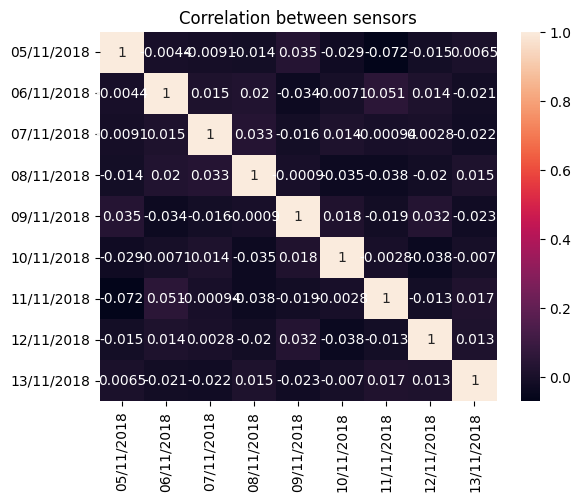

In [4]:

standard_days_df = standardize_dfs(days_df)
resampled_days = reshape_dfs(standard_days_df)
# print(standard_days_df)
correlate_dfs(days_df)

# for name, df in resampled_days.items():
#     for name2, df2 in resampled_days.items():
#         print(df.reset_index().head())
        # print(df2.to_numpy().flatten())
        # print()
        # print(np.correlate(df.to_numpy().flatten(), df2.to_numpy().flatten()))

# Multivariate gaussian 

In [5]:
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

In [6]:
sensors = {
    'PDT-92534': 6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':3278479880462408,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}

# I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# in the following dictionary, again with the sensor name as the key.


days = range(5, 14)
mv_days_df = {}

for day in days:
    startdate = datetime(2018, 11, day, tzinfo=timezone.utc)
    enddate = datetime(2018, 11, day+1, tzinfo=timezone.utc)

    df = pd.DataFrame(columns=sensors.keys())

    for k, v in sensors.items():
        res = c.time_series.data.retrieve_dataframe(id=v, 
                                                    start=startdate, 
                                                    end=enddate, 
                                                    column_names='id',
                                                    aggregates=["average"],
                                                    granularity="30s",)
        # Need to find a way to grab the unit of the time-series
        res = reshape_df(res)
        df[k] = res
    
    # plot_all_nine_sensors(df, title=f'Time series of the nine sensors on {startdate.strftime("%x")}')
    
    mv_days_df[startdate.strftime("%x")] = df

print("Data retrieved")

Data retrieved


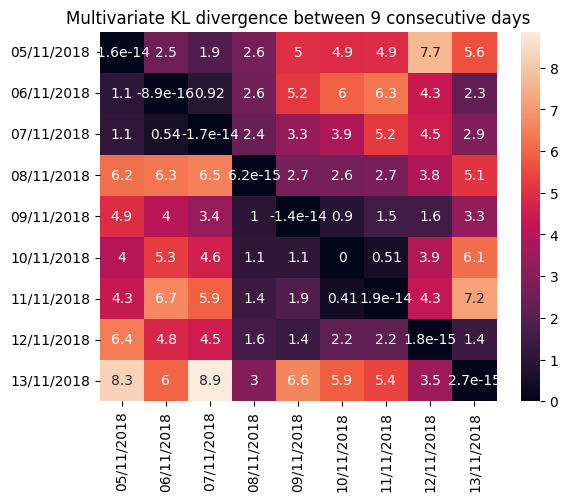

In [8]:
KL = mv_kl_dfs(mv_days_df)
plot_kl(KL, axis_labels=days_df.keys(), title="Multivariate KL divergence between 9 consecutive days")

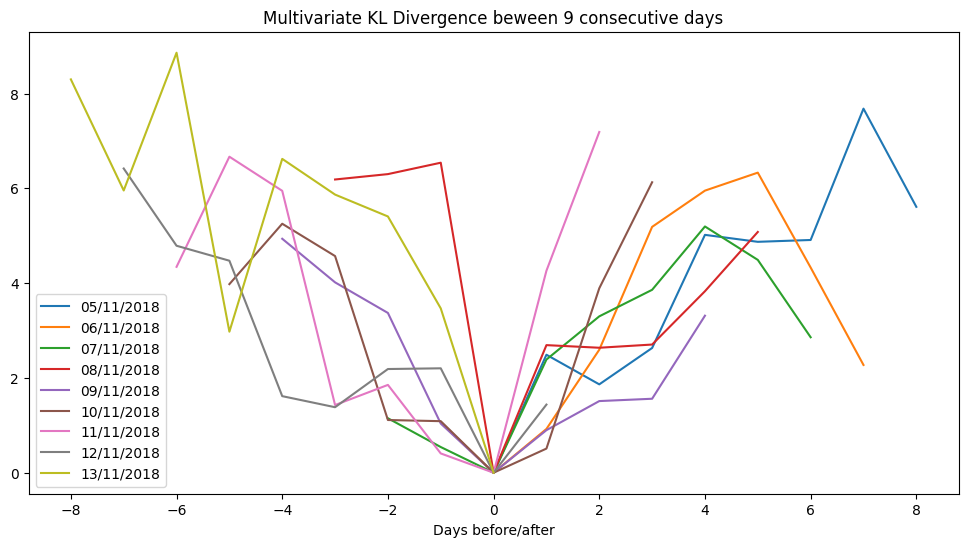

In [9]:
start_point = 0

plt.figure(figsize=(12,6))
for line in KL:
    x = range(start_point, start_point + 9)
    plt.plot(x, line)
    start_point -= 1
plt.legend(days_df.keys())
plt.xlabel('Days before/after')
plt.title('Multivariate KL Divergence beween 9 consecutive days')
plt.show()